In [58]:
import pandas as pd
import zipfile
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [60]:
torch.cuda.device_count()

1

In [61]:
zf = zipfile.ZipFile('House_Sale.zip')  #aloca o arquivo zip

house_data = pd.read_csv(zf.open('kc_house_data.csv')) # abre o arquivo CSV 'train.csv' presente dentro do ZIP

In [62]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [63]:
house_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21611.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.396095,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.128162,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [64]:
house_data_bak = house_data # salvando as colunas que iremos remover

## Clusterização dos dados geográficos

In [65]:
geo_data = house_data[['id', 'lat', 'long']].copy()

In [66]:
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      21613 non-null  int64  
 1   lat     21613 non-null  float64
 2   long    21613 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 506.7 KB


In [67]:
from sklearn.cluster import DBSCAN
kms_per_radian = 6371.0088
coords = geo_data.drop(['id'], axis=1).values
epsilon = 0.5 / kms_per_radian # convertendo 30km para rad, usaremos p/ a formula de distancia
cluster = DBSCAN(eps=epsilon, metric='haversine').fit(np.radians(coords))

In [68]:
house_data['cluster_id'] = cluster.labels_

In [69]:
# removendo dados que não iremos utilizar na classificação
house_data = house_data.drop(['id', 'date', 'lat', 'long', 'zipcode'], axis=1)


In [70]:
house_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,cluster_id
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,1340,5650,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,1690,7639,1
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,2720,8062,1
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,1360,5000,2
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,1800,7503,3


In [71]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21611 non-null  float64
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
 16  cluster_id     21613 non-null  int64  
dtypes: float64(4), int64(13)
memory usage: 2.8 MB


In [72]:
# como NaN sempre nos causa problemas, (1) retiramos esse atributo ou (2) preenchemos com valores médios
rows_to_remove = np.where(house_data['sqft_above'].isnull())

In [73]:
house_data = house_data.drop(rows_to_remove[0], axis=0)

Vamos estudar a distribuição dos preços dentro da base de dados

<AxesSubplot: >

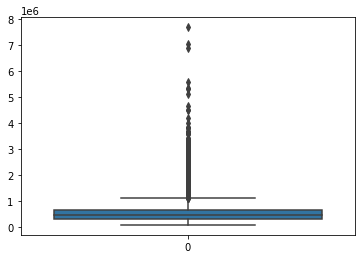

In [74]:
sns.boxplot(house_data['price'])

In [75]:
house_data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,cluster_id
count,2.161100e+04,21611.000000,21611.000000,21611.000000,2.161100e+04,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000
mean,5.400850e+05,3.370830,2.114791,2079.853454,1.510771e+04,1.494332,0.007542,0.234325,3.409421,7.656888,1788.396095,291.457360,1971.007959,84.410069,1986.559576,12769.025357,8.926334
std,3.671430e+05,0.930092,0.770157,918.422406,4.142235e+04,0.540003,0.086521,0.766350,0.650755,1.175502,828.128162,442.487355,29.372358,401.697007,685.416548,27305.369808,17.269812
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,399.000000,651.000000,-1.000000
25%,3.217250e+05,3.000000,1.750000,1426.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,1490.000000,5100.000000,1.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,1840.000000,7620.000000,2.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068850e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,2360.000000,10083.500000,9.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,6210.000000,871200.000000,116.000000


In [76]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21611 entries, 0 to 21612
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21611 non-null  float64
 1   bedrooms       21611 non-null  int64  
 2   bathrooms      21611 non-null  float64
 3   sqft_living    21611 non-null  int64  
 4   sqft_lot       21611 non-null  int64  
 5   floors         21611 non-null  float64
 6   waterfront     21611 non-null  int64  
 7   view           21611 non-null  int64  
 8   condition      21611 non-null  int64  
 9   grade          21611 non-null  int64  
 10  sqft_above     21611 non-null  float64
 11  sqft_basement  21611 non-null  int64  
 12  yr_built       21611 non-null  int64  
 13  yr_renovated   21611 non-null  int64  
 14  sqft_living15  21611 non-null  int64  
 15  sqft_lot15     21611 non-null  int64  
 16  cluster_id     21611 non-null  int64  
dtypes: float64(4), int64(13)
memory usage: 3.5 MB


In [77]:
y = house_data['price']
X = house_data.iloc[:, 1:]

Projetando a rede neural

In [78]:
print(f'num. atributos = {X.shape[1]}')

num. atributos = 16


In [79]:
# Define the neural network architecture
class BigNet(nn.Module):
    def __init__(self):
        super(BigNet, self).__init__()
        torch.set_default_tensor_type(torch.DoubleTensor)

        self.layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(16, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 8),
        nn.ReLU(),
        nn.Linear(8, 1)
        )

    def forward(self, x):

        return self.layers(x)

class LittleNet(nn.Module):
  def __init__(self):
    super(LittleNet, self).__init__()
    torch.set_default_tensor_type(torch.DoubleTensor)

    self.layers = nn.Sequential(
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.layers(x)



Para utilizarmos o recurso de mini-batches, vamos criar dataset e dataloaders

In [80]:
from torch.utils.data import Dataset, DataLoader
class HouseDataset(Dataset):
    def __init__(self, attributes, truths):
        self.features = attributes.values
        self.labels = truths.values
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float64)
        y = torch.tensor(self.labels[idx], dtype=torch.float64)
        return x, y

In [81]:
# 5-fold cross validation
y = house_data['price']
X = house_data.iloc[:, 1:17]
ds = HouseDataset(X,y)
kfold = KFold(n_splits=5, shuffle=True)

In [82]:
from tqdm import tqdm
def train_fn(model, loader, optimizer, scheduler, loss_fn, epoch):
  loop = tqdm(loader)
  loop.set_description(f"training | epoch {epoch}")
  for batch_idx, (data, target) in enumerate(loop):
    data = data.to(DEVICE)
    target = target.to(DEVICE)
    optimizer.zero_grad()

    # fwd
    outputs = model(data).squeeze() 
    loss = loss_fn(outputs, target)

    # bwd
    loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    # update prog bar
    loop.set_postfix({"loss": loss.item()})

  # update lr scheduler
  scheduler.step()
  
  return loss.item()
    

In [83]:
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score
def eval_fn(model, loader, epoch):
  loop = tqdm(loader)
  loop.set_description(f"validation | epoch {epoch}")
  for batch_idx, (data, target) in enumerate(loop):
    model.eval()
    data = data.to(DEVICE)
    target = target.to(DEVICE)

    outputs = model(data).squeeze()
    evs = explained_variance_score(target.cpu().detach().numpy(), outputs.cpu().detach().numpy())
    mape = mean_absolute_percentage_error(target.cpu().detach().numpy(), outputs.cpu().detach().numpy())
    loop.set_postfix({"mape": mape})
    
    model.train()
  return evs, mape





In [84]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
            print(f'Reset trainable parameters of layer {layer}')

In [85]:
global_losses = []
global_mapes = []
global_evss = []
partial_test_datasets = []
for fold, (train_ids, val_ids) in enumerate(kfold.split(ds)):
  DEVICE = "cuda"
  BATCH_SIZE = 256
  NUM_EPOCHS = 100
  model = BigNet().to(DEVICE)
  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(params=model.parameters(), lr=1e-3)
  scheduler = lr_scheduler.StepLR(optimizer, gamma=1, step_size=100) # disabling scheduler
  model.apply(reset_weights)
    
  print(f'========FOLD {fold+1}========')
  losses = []
  evss = []
  mapes = []
  min_mape_fold = np.inf
  max_evs_fold = 0

  # defining dataloaders for this fold
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
  train_loader = torch.utils.data.DataLoader(dataset=ds, batch_size=BATCH_SIZE,
                                             sampler=train_subsampler)
  val_loader = torch.utils.data.DataLoader(dataset=ds, batch_size = BATCH_SIZE,
                                            sampler = val_subsampler)

  for epoch in range(1, NUM_EPOCHS + 1): # training this fold
    loss = train_fn(model, train_loader, optimizer, scheduler, loss_fn, epoch)
    evs, mape = eval_fn(model, val_loader, epoch)
    if mape < min_mape_fold:
      min_mape = mape
      torch.save(model, f'models_big/Eduardo_Paulo_FOLD_{fold+1}.pth')
      max_evs = evs
    losses.append((epoch, loss))
    evss.append((epoch, evs))
    mapes.append((epoch, mape))
  
  model = (torch.load(f'models_big/Eduardo_Paulo_FOLD_{fold+1}.pth'))
  model.eval()
  preds_fold = model(torch.Tensor(X.iloc[val_ids, :].values).to(DEVICE))
  model.train()
  df_fold = pd.DataFrame(house_data.iloc[val_ids, :])
  df_fold['new_price'] = preds_fold.cpu().detach().numpy()
  partial_test_datasets.append(df_fold)

  global_losses.append(losses)
  global_evss.append(evss)
  global_mapes.append(mapes)


Reset trainable parameters of layer Linear(in_features=16, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=8, bias=True)
Reset trainable parameters of layer Linear(in_features=8, out_features=1, bias=True)
========FOLD 1========


training | epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 66.45it/s, loss=3.26e+11]
validation | epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 89.12it/s, mape=0.705]
training | epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 70.33it/s, loss=1.27e+11]
validation | epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 107.22it/s, mape=0.29]
training | epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 57.73it/s, loss=6.3e+10]
validation | epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 112.04it/s, mape=0.333]
training | epoch 4: 100%|███████████████████████████

validation | epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 130.99it/s, mape=0.288]
training | epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 82.95it/s, loss=7.4e+10]
validation | epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 77.86it/s, mape=0.296]
training | epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 83.19it/s, loss=5.08e+10]
validation | epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 110.17it/s, mape=0.278]
training | epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 86.44it/s, loss=7.3e+10]
validation | epoch 29: 100%|████████████████████████

training | epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 82.76it/s, loss=4.26e+10]
validation | epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 102.28it/s, mape=0.278]
training | epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 80.03it/s, loss=7.44e+10]
validation | epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 117.33it/s, mape=0.256]
training | epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 79.74it/s, loss=4.77e+10]
validation | epoch 54: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 84.94it/s, mape=0.268]
training | epoch 55: 100%|██████████████████████████

validation | epoch 77: 100%|███████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 80.19it/s, mape=0.3]
training | epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 74.46it/s, loss=6.43e+10]
validation | epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 103.53it/s, mape=0.284]
training | epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 74.28it/s, loss=1.04e+11]
validation | epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 108.35it/s, mape=0.278]
training | epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 87.69it/s, loss=3.43e+10]
validation | epoch 80: 100%|████████████████████████

Reset trainable parameters of layer Linear(in_features=16, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=8, bias=True)
Reset trainable parameters of layer Linear(in_features=8, out_features=1, bias=True)
========FOLD 2========


training | epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 73.47it/s, loss=2.49e+11]
validation | epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 82.52it/s, mape=0.642]
training | epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 70.11it/s, loss=1.18e+11]
validation | epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 92.68it/s, mape=0.324]
training | epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 59.07it/s, loss=1.17e+11]
validation | epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 80.43it/s, mape=0.318]
training | epoch 4: 100%|███████████████████████████

validation | epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 87.47it/s, mape=0.328]
training | epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 81.09it/s, loss=7.41e+10]
validation | epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 114.86it/s, mape=0.291]
training | epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 74.43it/s, loss=4.75e+10]
validation | epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 122.40it/s, mape=0.292]
training | epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 51.56it/s, loss=8.53e+10]
validation | epoch 29: 100%|████████████████████████

training | epoch 52: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 80.17it/s, loss=4.2e+10]
validation | epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 114.75it/s, mape=0.299]
training | epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 83.79it/s, loss=7.18e+10]
validation | epoch 53: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 81.42it/s, mape=0.287]
training | epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 83.72it/s, loss=1.72e+11]
validation | epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 108.36it/s, mape=0.317]
training | epoch 55: 100%|██████████████████████████

validation | epoch 77: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 89.27it/s, mape=0.296]
training | epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 86.14it/s, loss=4.93e+10]
validation | epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 131.17it/s, mape=0.291]
training | epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 81.31it/s, loss=9.26e+10]
validation | epoch 79: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 95.44it/s, mape=0.299]
training | epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 81.72it/s, loss=5.33e+10]
validation | epoch 80: 100%|████████████████████████

Reset trainable parameters of layer Linear(in_features=16, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=8, bias=True)
Reset trainable parameters of layer Linear(in_features=8, out_features=1, bias=True)
========FOLD 3========


training | epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 83.54it/s, loss=2.81e+11]
validation | epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 88.11it/s, mape=0.743]
training | epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 67.61it/s, loss=9.12e+10]
validation | epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 96.28it/s, mape=0.315]
training | epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 78.56it/s, loss=1.13e+11]
validation | epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 84.60it/s, mape=0.3]
training | epoch 4: 100%|███████████████████████████

validation | epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 124.50it/s, mape=0.315]
training | epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 74.49it/s, loss=7.63e+10]
validation | epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 111.15it/s, mape=0.286]
training | epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 77.67it/s, loss=7.45e+10]
validation | epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 91.27it/s, mape=0.28]
training | epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 59.75it/s, loss=5.45e+10]
validation | epoch 29: 100%|████████████████████████

training | epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 81.05it/s, loss=7.37e+10]
validation | epoch 52: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 87.97it/s, mape=0.298]
training | epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 64.37it/s, loss=6.85e+10]
validation | epoch 53: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 84.24it/s, mape=0.295]
training | epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 77.14it/s, loss=5.38e+10]
validation | epoch 54: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 96.02it/s, mape=0.283]
training | epoch 55: 100%|██████████████████████████

validation | epoch 77: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 107.48it/s, mape=0.297]
training | epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 85.54it/s, loss=6.15e+10]
validation | epoch 78: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 99.94it/s, mape=0.295]
training | epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 80.54it/s, loss=7.55e+10]
validation | epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 109.64it/s, mape=0.291]
training | epoch 80: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 79.58it/s, loss=9.1e+10]
validation | epoch 80: 100%|████████████████████████

Reset trainable parameters of layer Linear(in_features=16, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=8, bias=True)
Reset trainable parameters of layer Linear(in_features=8, out_features=1, bias=True)
========FOLD 4========


training | epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 83.89it/s, loss=3.2e+11]
validation | epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 133.79it/s, mape=0.686]
training | epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 59.15it/s, loss=6.48e+10]
validation | epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 74.12it/s, mape=0.297]
training | epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 80.11it/s, loss=7.44e+10]
validation | epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 83.28it/s, mape=0.339]
training | epoch 4: 100%|███████████████████████████

validation | epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 86.45it/s, mape=0.328]
training | epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 64.18it/s, loss=7.06e+10]
validation | epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 130.06it/s, mape=0.306]
training | epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 60.62it/s, loss=2.97e+11]
validation | epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 80.62it/s, mape=0.292]
training | epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 87.51it/s, loss=5.32e+10]
validation | epoch 29: 100%|████████████████████████

training | epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 80.00it/s, loss=6.23e+10]
validation | epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 129.48it/s, mape=0.301]
training | epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 61.78it/s, loss=4.49e+10]
validation | epoch 53: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 71.29it/s, mape=0.292]
training | epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 54.21it/s, loss=3.41e+10]
validation | epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 100.40it/s, mape=0.305]
training | epoch 55: 100%|██████████████████████████

validation | epoch 77: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 90.71it/s, mape=0.278]
training | epoch 78: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 74.13it/s, loss=7.4e+10]
validation | epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 104.85it/s, mape=0.286]
training | epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 73.21it/s, loss=9.71e+10]
validation | epoch 79: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 94.76it/s, mape=0.308]
training | epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 81.82it/s, loss=6.87e+10]
validation | epoch 80: 100%|████████████████████████

Reset trainable parameters of layer Linear(in_features=16, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=128, bias=True)
Reset trainable parameters of layer Linear(in_features=128, out_features=8, bias=True)
Reset trainable parameters of layer Linear(in_features=8, out_features=1, bias=True)
========FOLD 5========


training | epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 66.76it/s, loss=4.19e+11]
validation | epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 109.32it/s, mape=0.724]
training | epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 80.61it/s, loss=1.32e+11]
validation | epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 81.83it/s, mape=0.361]
training | epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 83.88it/s, loss=1.18e+11]
validation | epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 131.67it/s, mape=0.367]
training | epoch 4: 100%|███████████████████████████

validation | epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 132.76it/s, mape=0.281]
training | epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 78.10it/s, loss=1.12e+11]
validation | epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 45.68it/s, mape=0.317]
training | epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 83.13it/s, loss=8.17e+10]
validation | epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 141.29it/s, mape=0.281]
training | epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 83.76it/s, loss=1.04e+11]
validation | epoch 29: 100%|████████████████████████

training | epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 84.91it/s, loss=5.24e+10]
validation | epoch 52: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 75.35it/s, mape=0.301]
training | epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 63.25it/s, loss=5.57e+10]
validation | epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 43.66it/s, mape=0.29]
training | epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 82.88it/s, loss=1.37e+11]
validation | epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 113.88it/s, mape=0.305]
training | epoch 55: 100%|██████████████████████████

validation | epoch 77: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 94.49it/s, mape=0.283]
training | epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 84.13it/s, loss=8.81e+10]
validation | epoch 78: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 129.40it/s, mape=0.298]
training | epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 82.13it/s, loss=8.54e+10]
validation | epoch 79: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 95.14it/s, mape=0.279]
training | epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 64.09it/s, loss=6.49e+10]
validation | epoch 80: 100%|████████████████████████

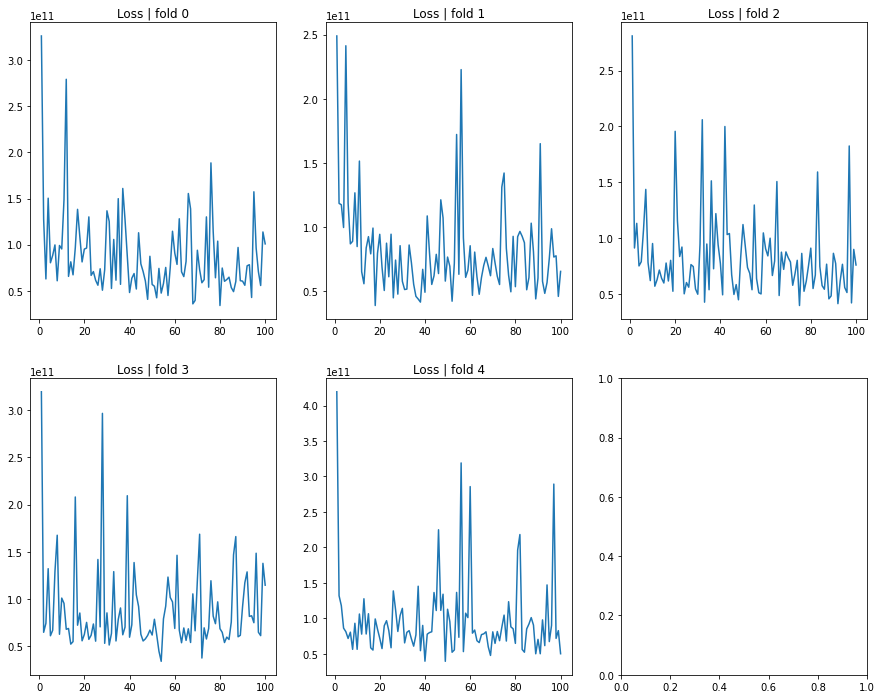

In [86]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12))
for i in range(2):
    for j in range(3):
        if 3*i + j == 5:
            break
        losses = global_losses[3*i + j]
        x_val = [x[0] for x in losses]
        y_val = [x[1] for x in losses]
        ax[i,j].set_title(f"Loss | fold {3*i + j}")
        ax[i,j].plot(x_val, y_val)

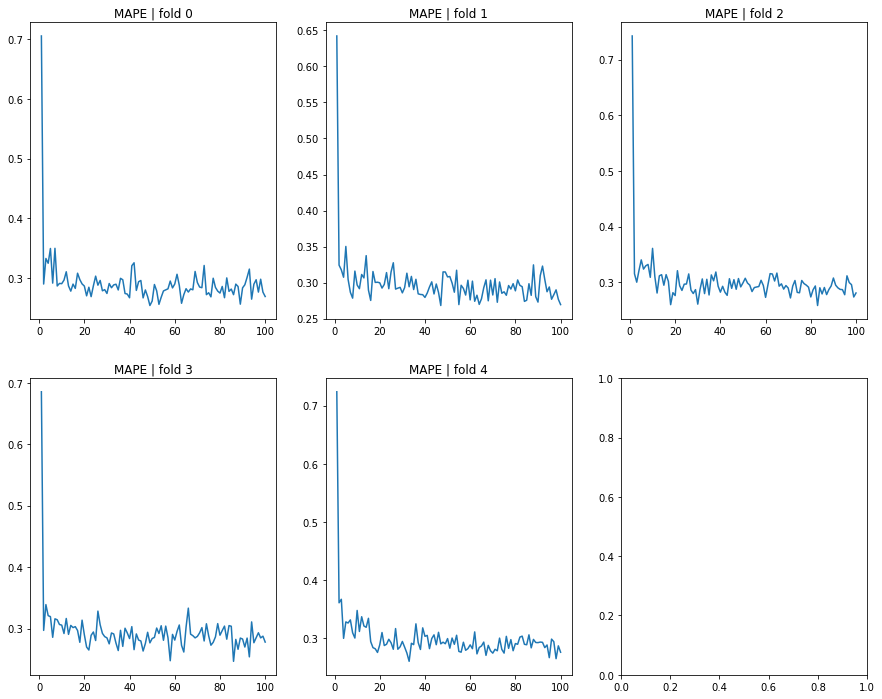

In [87]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12))
for i in range(2):
    for j in range(3):
        if 3*i + j == 5:
            break
        mapes = global_mapes[3*i + j]
        x_val = [x[0] for x in mapes]
        y_val = [x[1] for x in mapes]
        ax[i,j].set_title(f"MAPE | fold {3*i + j}")
        ax[i,j].plot(x_val, y_val)

In [88]:
min_mapes = []
for fold, arr in enumerate(global_mapes):
    mapes_fold = [tup[1] for tup in arr]
    print(f'Min MAPE for fold {fold + 1}: {min(mapes_fold) :.3f}')
    min_mapes.append(min(mapes_fold))

Min MAPE for fold 1: 0.254
Min MAPE for fold 2: 0.268
Min MAPE for fold 3: 0.258
Min MAPE for fold 4: 0.247
Min MAPE for fold 5: 0.261


In [89]:
print(f'avg min MAPE: {np.array(min_mapes).mean() :.3f}')

avg min MAPE: 0.257


In [90]:
# juntando os datasets
full_df = pd.concat(partial_test_datasets)

In [91]:
full_df.shape

(21611, 18)

In [92]:
house_data_bak.shape

(21613, 22)

In [93]:
full_df = full_df.reset_index()

In [94]:
full_df.head()

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,cluster_id,new_price
0,1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,1690,7639,1,649488.537556
1,8,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050.0,730,1960,0,1780,8113,2,364058.991210
2,21,2000000.0,3,2.75,3050,44867,1.0,0,4,3,9,2330.0,720,1968,0,4110,20336,8,708191.989774
3,26,937000.0,3,1.75,2450,2691,2.0,0,0,3,8,1750.0,700,1915,0,1760,3573,10,487276.030220
4,30,580500.0,3,2.50,2320,3980,2.0,0,0,3,8,2320.0,0,2003,0,2580,3980,12,477167.541709


In [95]:
house_data_bak = house_data_bak.reset_index()

In [96]:
house_data_bak.head()

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,cluster_id
0,0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,...,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650,0
1,1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,...,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639,1
2,2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,...,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062,1
3,3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,...,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000,2
4,4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,...,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503,3


In [98]:
full_df.columns

Index(['index', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'cluster_id', 'new_price'],
      dtype='object')

In [103]:
export = full_df.merge(house_data_bak[['index','lat','long','id','zipcode']], on='index')

In [105]:
export.drop(['index'], axis=1, inplace=True)
export.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,sqft_living15,sqft_lot15,cluster_id,new_price,lat,long,id,zipcode
0,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,1951,1991,1690,7639,1,649488.537556,47.7210,-122.319,6414100192,98125
1,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,...,1960,0,1780,8113,2,364058.991210,47.5123,-122.337,2414600126,98146
2,2000000.0,3,2.75,3050,44867,1.0,0,4,3,9,...,1968,0,4110,20336,8,708191.989774,47.5316,-122.233,2524049179,98040
3,937000.0,3,1.75,2450,2691,2.0,0,0,3,8,...,1915,0,1760,3573,10,487276.030220,47.6386,-122.360,1794500383,98119
4,580500.0,3,2.50,2320,3980,2.0,0,0,3,8,...,2003,0,2580,3980,12,477167.541709,47.5391,-122.070,8562750320,98027


In [106]:
export.to_csv('export.csv', index=False)

In [35]:
true_mape = mean_absolute_percentage_error(full_df['price'].values, full_df['new_price'].values)
print(f'True avg MAPE: {true_mape :.3f}')

True avg MAPE: 0.286


In [40]:
diff = abs(full_df['price'] - full_df['new_price'])
diff

0         41990.313458
18        49118.315295
34       103573.586931
39        92516.100482
45       139748.561481
             ...      
21573    113098.967164
21583    134290.007865
21588    126356.127452
21604    105755.475634
21606    224317.158362
Length: 21611, dtype: float64

<AxesSubplot: ylabel='Count'>

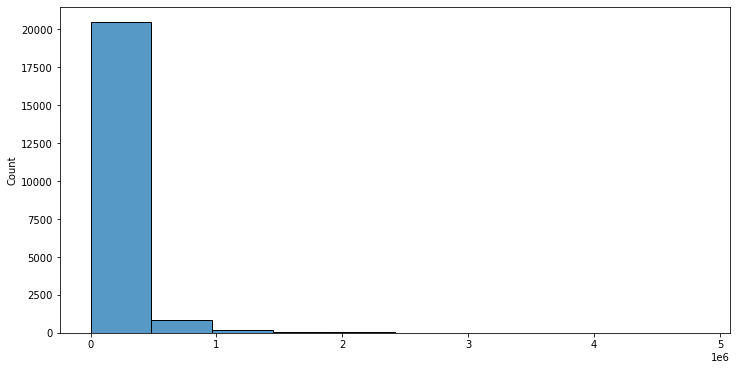

In [47]:
plt.figure(figsize=(12,6))
sns.histplot(diff.values, bins=10)

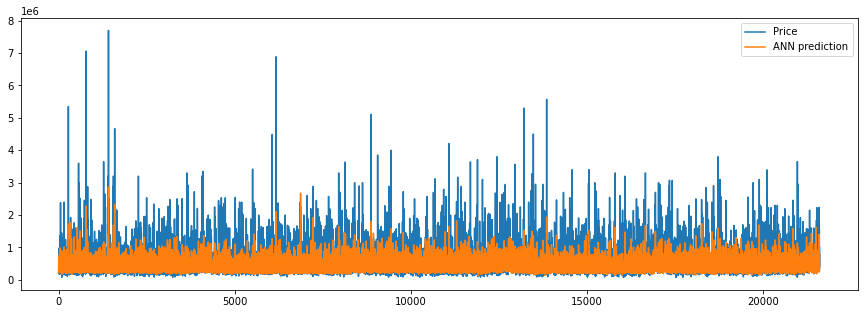

In [73]:
ann_outcomes = pd.DataFrame({'Price': full_df['price'], 'ANN prediction': full_df['new_price']})
ann_outcomes = ann_outcomes.reset_index()
ann_outcomes.drop(['index'], axis=1, inplace=True)
plt.figure(figsize=(15,5))
plt.plot(ann_outcomes)
plt.legend(ann_outcomes.columns)